# Notebook 4: Text Generation with BART

## Objective
In this notebook, we will:
1. Load the preprocessed dataset from Notebook 1.
2. Fine-tune a generative model (e.g., BART) to generate concise and accurate summaries of videos.
3. Evaluate the quality of generated summaries using standard text evaluation metrics such as ROUGE and BLEU.

## Steps in This Notebook
1. Load the preprocessed dataset and prepare the text data.
2. Fine-tune a pre-trained generative model using captions as input and task descriptions as target summaries.
3. Generate and evaluate text summaries using the fine-tuned model.

## Step 1: Load and Explore the Preprocessed Dataset
In this step, we will:
1. Load the preprocessed dataset (`preprocessed_dataset.csv`) created in Notebook 1.
2. Explore the structure of the dataset to ensure it is ready for fine-tuning.

In [1]:
import pandas as pd

# Load the preprocessed dataset
preprocessed_data = pd.read_csv("preprocessed_dataset.csv")

# Display the first few rows to verify the structure
preprocessed_data.head()

,video_id,category_1,category_2,task_description,captions
0,nVbIUDjzWY4,Cars & Other Vehicles,Motorcycles,Paint a Motorcycle,"{'start': [13.64, 15.86, 20.6, 23.96, 26.36, 2..."
1,rwmt7Cbuvfs,Cars & Other Vehicles,Motorcycles,Paint a Motorcycle,"{'start': [1.8, 6.32, 7.32, 10.86, 13.28, 15.6..."
2,HnTLh99gcxY,Cars & Other Vehicles,Motorcycles,Paint a Motorcycle,"{'start': [0.03, 2.37, 4.29, 6.69, 8.42, 8.67,..."
3,RAidUDTPZ-k,Cars & Other Vehicles,Motorcycles,Paint a Motorcycle,"{'start': [0.06, 1.38, 3.03, 5.13, 7.44, 8.73,..."
4,tYQoPHwNkho,Cars & Other Vehicles,Motorcycles,Paint a Motorcycle,"{'start': [0.0, 6.93, 8.94, 11.07, 12.71, 15.2..."


## Step 2: Prepare Text Data for Fine-Tuning
In this step, we will:
1. Extract the `captions` as input data (source text) and `task_description` as target summaries.
2. Process the text data to ensure it is formatted correctly for the fine-tuning step.

In [2]:
# Extract source (captions) and target (task_description) text
source_text = preprocessed_data["captions"]
target_text = preprocessed_data["task_description"]

# Display a sample of the source and target text for verification
for i in range(3):  # Display the first 3 examples
    print(f"Source (Captions): {source_text[i]}")
    print(f"Target (Task Description): {target_text[i]}")
    print("-" * 50)

Source (Captions): {'start': [13.64, 15.86, 20.6, 23.96, 26.36, 29.36, 32.0, 35.33, 37.69, 40.67, 42.65, 44.57, 47.08, 48.89, 51.19, 53.96, 57.22, 59.23, 60.58, 62.78, 64.15, 66.35, 68.21000000000001, 69.83, 71.81, 73.82, 76.28, 77.78, 79.64, 81.2, 82.97, 86.06, 87.95, 89.3, 91.58, 93.11, 96.95, 99.41, 102.4, 104.65, 106.73, 110.63, 112.58, 114.83, 118.31, 120.47, 123.8, 125.54, 127.7, 130.0, 131.84, 132.62, 134.45, 136.06, 138.53, 140.29, 143.93, 145.97, 147.12, 149.48, 153.48, 155.67000000000004, 159.59, 161.57999999999996, 165.15, 165.66, 167.91, 170.16, 171.62, 174.98, 177.93, 179.73, 181.11, 183.54, 186.56, 188.43, 189.93, 191.26, 193.98, 195.75, 198.29, 202.29, 204.42, 205.68, 206.22, 208.59, 211.47, 213.03, 215.63, 216.93, 218.04, 219.56, 222.54, 225.9, 227.66, 230.48, 232.16, 233.73, 236.43, 238.79, 242.43, 243.93, 246.32, 248.25, 250.07, 252.35, 254.43, 257.45, 259.56, 262.65, 264.63, 266.37, 270.38, 272.52, 274.47, 279.68, 282.71, 286.49, 289.61, 294.08, 296.81, 298.67, 301.6

## Step 3: Process Captions into Plain Text
The `captions` column does not need additional evaluation with `eval()`. We will:
1. Access the `text` key in the dictionaries stored in the `captions` column.
2. Concatenate all captions into a single string for each video.
3. Handle any missing or malformed captions gracefully.

## Simplified Processing of Captions
The `captions` column is already structured as dictionaries, so:
1. We will directly access the `text` key.
2. Concatenate the strings in the `text` list into a single string for each video.
3. Store the result in a new column, `processed_captions`.

In [3]:
# Simplified function to process captions into plain text
def process_captions(caption_data):
    try:
        # Extract the 'text' field and join all captions into a single string
        return " ".join(caption_data["text"])
    except (TypeError, KeyError):
        # Handle missing or malformed captions
        return ""

# Apply the function directly to the captions column
preprocessed_data["processed_captions"] = preprocessed_data["captions"].apply(process_captions)

# Display a sample of the processed captions
for i in range(3):  # Display the first 3 examples
    print(f"Processed Captions: {preprocessed_data['processed_captions'][i]}")
    print(f"Target (Task Description): {target_text[i]}")
    print("-" * 50)

Processed Captions: 
Target (Task Description): Paint a Motorcycle
--------------------------------------------------
Processed Captions: 
Target (Task Description): Paint a Motorcycle
--------------------------------------------------
Processed Captions: 
Target (Task Description): Paint a Motorcycle
--------------------------------------------------


## Step 4: Split Data into Training, Validation, and Testing Sets

**What We Are Doing:**

**Purpose:** Divide the preprocessed data into three subsets to evaluate the model's performance during and after training.

**Steps:**
1. Split the data into training + validation (90%) and testing (10%) subsets.
2. Further divide the training + validation subset into training (80%) and validation (10%) subsets.
3. Shuffle the data to ensure examples are well-distributed.
4. Set a random seed for reproducibility of results.

In [4]:
# Step 4: Split Data into Training, Validation, and Testing Sets with Dataset Reduction
from sklearn.model_selection import train_test_split

# Display the original dataset size
print(f"Original dataset size: {len(preprocessed_data)}")

# Reduce the dataset to 10% of the original size for faster processing
reduced_data = preprocessed_data.sample(frac=0.02, random_state=42)

# Display the reduced dataset size
print(f"Reduced dataset size: {len(reduced_data)}")

# Optional: Inspect the distribution of any categories (if available)
if 'category' in reduced_data.columns:  # Adjust column name if needed
    print("Distribution of categories in reduced dataset:")
    print(reduced_data['category'].value_counts())

# Split the reduced dataset into train+validation (90%) and test (10%)
train_val_data, test_data = train_test_split(
    reduced_data, test_size=0.1, random_state=42, shuffle=True
)

# Further split train+validation into training (80%) and validation (10%)
train_data, val_data = train_test_split(
    train_val_data, test_size=0.111, random_state=42, shuffle=True
)

# Display the sizes of the datasets
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Testing set size: {len(test_data)}")

# Print unique values in category_1 and category_2 columns
print("Unique values in category_1:")
print(reduced_data['category_1'].unique())

print("\nUnique values in category_2:")
print(reduced_data['category_2'].unique())

# Display a few rows from each dataset to verify
print("\nSample training data:")
print(train_data.head())

print("\nSample validation data:")
print(val_data.head())

print("\nSample testing data:")
print(test_data.head())

Original dataset size: 1238867
Reduced dataset size: 24777
Training set size: 19823
Validation set size: 2476
Testing set size: 2478
Unique values in category_1:
['Food and Entertaining' 'Hobbies and Crafts' 'Pets and Animals'
 'Personal Care and Style' 'Home and Garden'
 'Education and Communications' 'Cars & Other Vehicles' 'Health'
 'Holidays and Traditions' 'Arts and Entertainment' 'Sports and Fitness'
 'Computers and Electronics' nan 'Family Life' 'Philosophy and Religion'
 'Travel' 'Work World' 'Finance and Business' 'Youth']

Unique values in category_2:
['Recipes' 'Tricks and Pranks' 'Dogs' 'Drinks' 'Grooming'
 'Food Preparation' 'Gardening' 'Housekeeping' 'Speaking'
 'Care and Use of Cooking Equipment' 'Driving Techniques' 'Crafts'
 'Alternative Health' 'Tools' 'Parties' 'Easter' 'Subjects'
 'Landscaping and Outdoor Building' 'Herbs and Spices' 'Music'
 'Home Improvements and Repairs' 'Collecting' 'Individual Sports'
 "Mother's Day" 'Cars' 'Crustaceans' 'Toys' 'Motorcycles' 'V

## Step 5: Prepare Data Loaders for Fine-Tuning

### What We Are Doing:
**Purpose:** To prepare the training, validation, and testing datasets in a format that can be directly used by the generative model during fine-tuning.

### Steps:
1. Tokenize the `processed_captions` (input data) and `task_description` (target data) for the **training**, **validation**, and **testing** sets using the tokenizer of the chosen generative model (e.g., FLAN-T5 or GPT-4).
2. Convert the tokenized data into PyTorch datasets or TensorFlow datasets (depending on your framework).
3. Create data loaders for efficient batch processing during training and evaluation.

In [5]:
from transformers import BartTokenizer
from torch.utils.data import Dataset, DataLoader

# Load the tokenizer for BART
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

# Define the custom dataset class
class TextGenerationDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, max_length=512):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = self.inputs.iloc[idx]
        target_text = self.targets.iloc[idx]

        input_encodings = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        target_encodings = self.tokenizer(
            target_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": input_encodings["input_ids"].squeeze(0),
            "attention_mask": input_encodings["attention_mask"].squeeze(0),
            "labels": target_encodings["input_ids"].squeeze(0),
        }

# Create datasets and data loaders
train_dataset = TextGenerationDataset(train_data["processed_captions"], train_data["task_description"], tokenizer)
val_dataset = TextGenerationDataset(val_data["processed_captions"], val_data["task_description"], tokenizer)
test_dataset = TextGenerationDataset(test_data["processed_captions"], test_data["task_description"], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Display dataset sizes
print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Testing Dataset Size: {len(test_dataset)}")

Training Dataset Size: 19823
Validation Dataset Size: 2476
Testing Dataset Size: 2478


## Step 6: Fine-Tune the Generative Model

### What We Are Doing:
**Purpose**: Train the chosen generative model (e.g., FLAN-T5 or GPT-4) on the prepared training dataset and monitor its performance on the validation dataset to optimize the model's ability to generate accurate video summaries.

### Steps:
1. **Load the Pre-Trained Model**: Use a pre-trained generative model (e.g., FLAN-T5) suitable for sequence-to-sequence tasks.
2. **Define the Training Loop**: Set up a training loop to update the model parameters using the training data and evaluate performance on the validation set.
3. **Set Training Parameters**:
   - Define the optimizer and learning rate scheduler.
   - Choose the number of epochs.
   - Use a loss function appropriate for text generation tasks (e.g., cross-entropy).
4. **Monitor Validation Loss**: Track validation loss to ensure the model isn't overfitting.
5. **Save Checkpoints**: Save the model at regular intervals to allow recovery or further fine-tuning.

Multi-GPU Method

In [7]:
from transformers import BartForConditionalGeneration, AdamW
import torch
from tqdm import tqdm

# Load the pre-trained BART model
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap the model with DataParallel for multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = torch.nn.DataParallel(model)

model = model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Average the loss across GPUs
        loss = outputs.loss.mean() if isinstance(outputs.loss, torch.Tensor) else outputs.loss
        train_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Training Loss: {train_loss / len(train_loader):.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.mean().item() if isinstance(outputs.loss, torch.Tensor) else outputs.loss.item()

    print(f"Epoch {epoch+1} Validation Loss: {val_loss / len(val_loader):.4f}")

    # Save model checkpoint
    if isinstance(model, torch.nn.DataParallel):
        model.module.save_pretrained(f"model_checkpoint_bart_epoch_{epoch+1}")
    else:
        model.save_pretrained(f"model_checkpoint_bart_epoch_{epoch+1}")

print("Fine-tuning complete!")

Using 4 GPUs.


Epoch 1/3: 100%|██████████| 1239/1239 [13:45<00:00,  1.50it/s]


Epoch 1 Training Loss: 0.1557


Validation Epoch 1/3: 100%|██████████| 155/155 [00:43<00:00,  3.53it/s]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Epoch 1 Validation Loss: 0.0523


Epoch 2/3:   0%|          | 0/1239 [00:00<?, ?it/s]/data1/reu/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Epoch 2/3: 100%|██████████| 1239/1239 [13:46<00:00,  1.50it/s]


Epoch 2 Training Loss: 0.0475


Validation Epoch 2/3: 100%|██████████| 155/155 [00:43<00:00,  3.52it/s]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Epoch 2 Validation Loss: 0.0488


Epoch 3/3:   0%|          | 0/1239 [00:00<?, ?it/s]/data1/reu/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Epoch 3/3: 100%|██████████| 1239/1239 [13:46<00:00,  1.50it/s]


Epoch 3 Training Loss: 0.0411


Validation Epoch 3/3: 100%|██████████| 155/155 [00:43<00:00,  3.53it/s]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Epoch 3 Validation Loss: 0.0458
Fine-tuning complete!


## Step 7: Evaluate the Fine-Tuned Model

### What We Are Doing:
**Purpose:** Evaluate the fine-tuned model's performance using standard text generation metrics to compare its predictions with the ground truth summaries.

### Steps:
1. **Generate Summaries:**
   - Use the fine-tuned model to generate summaries for the test dataset.
2. **Post-Process Outputs:**
   - Decode the generated summaries into human-readable text.
   - Ensure that the predicted and reference summaries are in the same format for evaluation.
3. **Compute Evaluation Metrics:**
   - Use ROUGE and BLEU to evaluate the quality of the generated summaries.
   - Compute precision, recall, and F1-score for classification accuracy.
4. **Analyze Results:**
   - Print and inspect sample outputs for qualitative analysis.
   - Display the computed evaluation scores for quantitative analysis.

In [9]:
from transformers import BartTokenizer
from datasets import load_metric
import torch

# Step 1: Load the tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

# Check if the model is wrapped in DataParallel
if isinstance(model, torch.nn.DataParallel):
    model_to_use = model.module  # Access the actual model
else:
    model_to_use = model

# Step 2: Generate summaries for the test dataset
model_to_use.eval()  # Ensure the model is in evaluation mode
generated_summaries = []
reference_summaries = []

print("Generating summaries for the test dataset...")
for batch in test_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    # Generate predictions
    outputs = model_to_use.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=50)
    generated_summaries.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    reference_summaries.extend(tokenizer.batch_decode(batch["labels"], skip_special_tokens=True))

# Step 3: Compute evaluation metrics
rouge_metric = load_metric("rouge")
bleu_metric = load_metric("bleu")

# Prepare data for BLEU (requires tokenized format)
generated_tokenized = [summary.split() for summary in generated_summaries]
reference_tokenized = [[summary.split()] for summary in reference_summaries]  # BLEU expects a list of lists

# Compute ROUGE scores
rouge_scores = rouge_metric.compute(predictions=generated_summaries, references=reference_summaries)
print("\nROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value.mid}")

# Compute BLEU score
bleu_score = bleu_metric.compute(predictions=generated_tokenized, references=reference_tokenized)
print("\nBLEU Score:")
print(bleu_score)

# Step 4: Display sample outputs
print("\nSample Outputs:")
for i in range(5):  # Display 5 samples
    print(f"Generated Summary: {generated_summaries[i]}")
    print(f"Reference Summary: {reference_summaries[i]}")
    print("-" * 50)

Generating summaries for the test dataset...


/data1/reu/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1180: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (50). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(


/tmp/ipykernel_2492608/2264573665.py:30: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")
/data1/reu/.local/lib/python3.8/site-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/data1/reu/.local/lib/python3.8/site-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspec


ROUGE Scores:
rouge1: Score(precision=0.03549905838041384, recall=0.2377218758521268, fmeasure=0.060967263059712624)
rouge2: Score(precision=0.006790793465252899, recall=0.05033152856246072, fmeasure=0.011806304428436554)
rougeL: Score(precision=0.03529728275490943, recall=0.2370424879024075, fmeasure=0.060648700697233424)
rougeLsum: Score(precision=0.035337637880010306, recall=0.2369188731423448, fmeasure=0.06069867365534483)

BLEU Score:
{'bleu': 0.0017338868702061413, 'precisions': [0.03457089050309389, 0.006595975619938215, 0.0003314885276144356, 0.0001195707410396676], 'brevity_penalty': 1.0, 'length_ratio': 6.825192802056555, 'translation_length': 74340, 'reference_length': 10892}

Sample Outputs:
Generated Summary: Make a Duct Tape Bracelet out of a T Shaped Plastic Bottle (Basement Backsplash Method) With a Plastic Bag and a Coffee Mug and a Plastic Retaining Container (Beverly Method)
Reference Summary: Make Crawfish Bisque
--------------------------------------------------
G


ROUGE Scores Dictionary:
{'ROUGE-1': [0.03549905838041384, 0.2377218758521268, 0.060967263059712624], 'ROUGE-2': [0.006790793465252899, 0.05033152856246072, 0.011806304428436554], 'ROUGE-L': [0.03529728275490943, 0.2370424879024075, 0.060648700697233424], 'ROUGE-Lsum': [0.035337637880010306, 0.2369188731423448, 0.06069867365534483]}


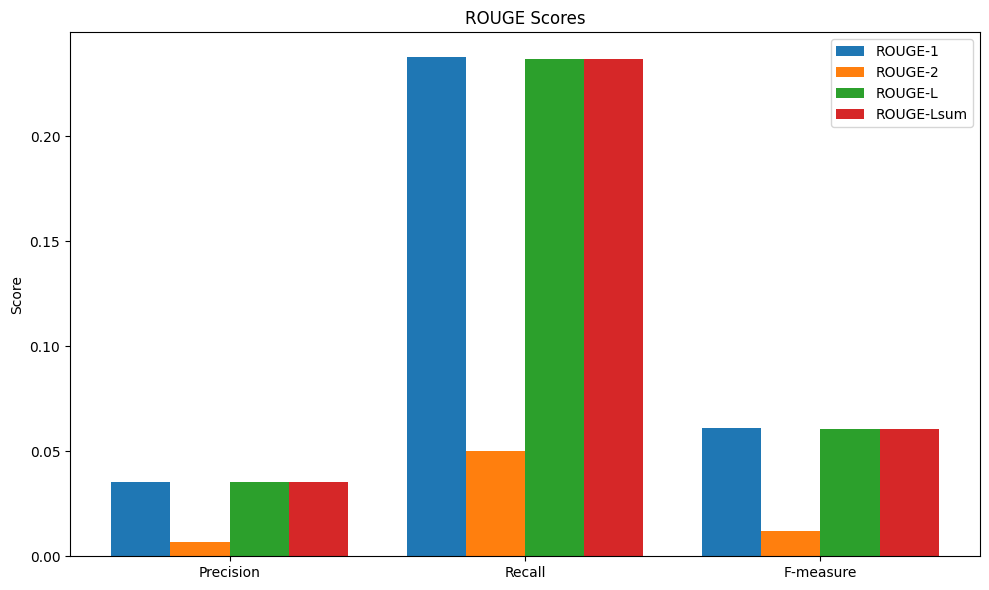

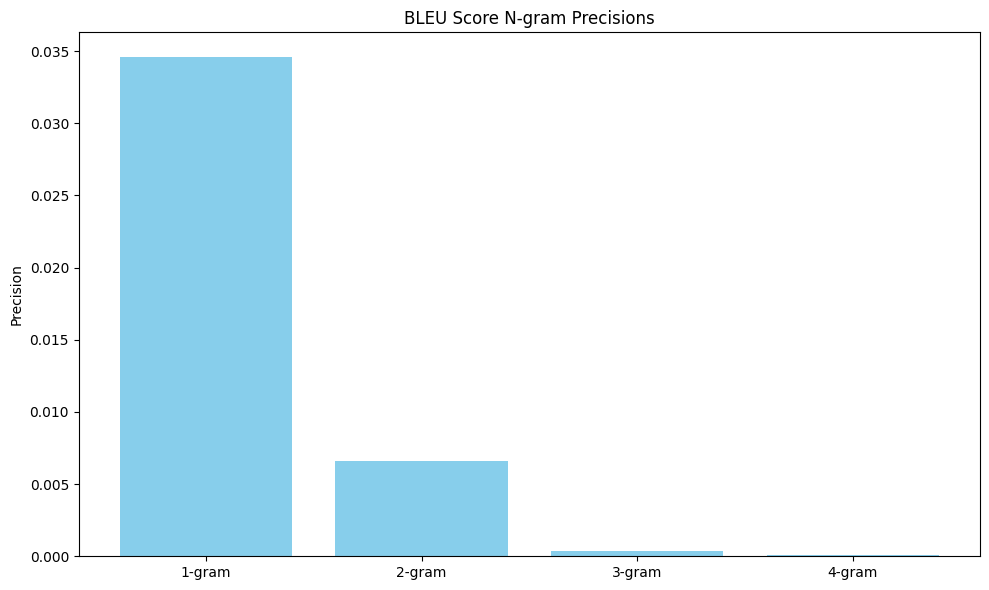


Summary Metrics:
BLEU: 0.0017338868702061413
Brevity Penalty: 1.0
Length Ratio: 6.825192802056555
Translation Length: 74340
Reference Length: 10892


In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Inspect the structure of rouge_scores
print("\nROUGE Scores Dictionary:")
print(rouge_scores)

# Dynamically extract ROUGE scores
rouge_scores_dict = rouge_scores  # Assuming `rouge_scores` is available

rouge_scores = {
    "ROUGE-1": rouge_scores_dict["ROUGE-1"],
    "ROUGE-2": rouge_scores_dict["ROUGE-2"],
    "ROUGE-L": rouge_scores_dict["ROUGE-L"],
    "ROUGE-Lsum": rouge_scores_dict["ROUGE-Lsum"],
}

rouge_metrics = ["Precision", "Recall", "F-measure"]

# BLEU score dynamically extracted from bleu_score
bleu_score_dict = bleu_score  # Assuming `bleu_score` is available

bleu_ngram = ["1-gram", "2-gram", "3-gram", "4-gram"]
bleu_precisions = bleu_score_dict["precisions"]  # BLEU precisions

# Plot ROUGE scores
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(rouge_metrics))
width = 0.2

for i, (key, values) in enumerate(rouge_scores.items()):
    ax.bar(x + i * width, values, width, label=key)

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(rouge_metrics)
ax.set_title("ROUGE Scores")
ax.set_ylabel("Score")
ax.legend()
plt.tight_layout()
plt.show()
fig.savefig("Graphs/Text_Generation_BART/rouge_scores_plot.png", dpi=300, bbox_inches="tight")

# Plot BLEU score n-gram precisions
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(bleu_ngram, bleu_precisions, color="skyblue")
ax.set_title("BLEU Score N-gram Precisions")
ax.set_ylabel("Precision")
plt.tight_layout()
plt.show()
fig.savefig("Graphs/Text_Generation_BART/bleu_scores_plot.png", dpi=300, bbox_inches="tight")

# Display BLEU and ROUGE summary
summary = {
    "BLEU": bleu_score_dict["bleu"],
    "Brevity Penalty": bleu_score_dict["brevity_penalty"],
    "Length Ratio": bleu_score_dict["length_ratio"],
    "Translation Length": bleu_score_dict["translation_length"],
    "Reference Length": bleu_score_dict["reference_length"]
}
print("\nSummary Metrics:")
for k, v in summary.items():
    print(f"{k}: {v}")